In [1]:
import os
import random
import librosa
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

# --- Set paths ---
speech_path = "/kaggle/input/radvess-audio-only-data/Audio_Speech_Actors_01-24"
song_path = "/kaggle/input/radvess-audio-only-data/Audio_Song_Actors_01-24"

# --- Emotion map ---
emotion_map = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}

# --- 1. Load all audio and labels into X and y ---
X = []
y = []

def load_audio(modality_path):
    for actor in sorted(os.listdir(modality_path)):
        actor_path = os.path.join(modality_path, actor)
        if not os.path.isdir(actor_path): continue
        for fname in os.listdir(actor_path):
            if fname.endswith(".wav"):
                parts = fname.split("-")
                emotion_id = parts[2]
                emotion = emotion_map.get(emotion_id)
                if emotion is None:
                    continue
                file_path = os.path.join(actor_path, fname)
                try:
                    audio, _ = librosa.load(file_path, sr=None)
                    X.append(audio)
                    y.append(emotion)
                except Exception as e:
                    print(f"Error loading {file_path}: {e}")

load_audio(speech_path)
load_audio(song_path)

print(f"Loaded {len(X)} audio files.")

# --- 2. Extract MFCCs ---
def extract_mfcc_batch(waveforms, sr=22050, n_mfcc=50):
    mfccs = []
    for x in waveforms:
        m = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=n_mfcc).T  # shape: (T, 40)
        mfccs.append(m)
    return mfccs

mfccs = extract_mfcc_batch(X)

# --- 3. Pad all MFCCs to same length ---
max_len = max([m.shape[0] for m in mfccs])
X_padded = pad_sequences(mfccs, maxlen=max_len, padding='post', dtype='float32')  # shape: (N, T, 40)

# --- 4. Encode labels ---
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# --- 5. Train/val split (80/20) ---
X_train, X_val, y_train, y_val = train_test_split(X_padded, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# --- 6. Final shapes ---
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)
print("Classes:", encoder.classes_)

2025-06-25 16:04:10.264793: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750867450.448046      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750867450.501863      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loaded 2452 audio files.
X_train: (1961, 598, 50)
y_train: (1961,)
X_val: (491, 598, 50)
y_val: (491,)
Classes: ['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Activation, Dropout, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint

# New input shape: (timesteps, 40) for MFCC
input_shape = (X_train.shape[1], X_train.shape[2])  # (T, 40)

dr= 0.5

model = Sequential()
model.add(Conv1D(128, 5, padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(Dropout(dr))
model.add(MaxPooling1D(pool_size=8))
model.add(Conv1D(128, 5, padding='same'))
model.add(Activation('relu'))
model.add(Dropout(dr))
model.add(Flatten())
model.add(Dense(8))  # 8 emotion classes
model.add(Activation('softmax'))

opt = RMSprop(learning_rate=0.00005, rho=0.9)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1750867570.701415      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 598, 128)            │          32,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 598, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 598, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 74, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 74, 128)             │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 74, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 74, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9472)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │          75,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 8)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 189,960 (742.03 KB)

 Trainable params: 189,960 (742.03 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
cnnhistory = model.fit(
    X_train, y_train,
    batch_size=128,
    epochs=300,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint]
)

Epoch 1/300
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9849 - loss: 0.0472
Epoch 1: val_accuracy did not improve from 0.75967
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9850 - loss: 0.0466 - val_accuracy: 0.7393 - val_loss: 1.0767
Epoch 2/300
11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9824 - loss: 0.0514
Epoch 2: val_accuracy did not improve from 0.75967
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9813 - loss: 0.0531 - val_accuracy: 0.7515 - val_loss: 1.0602
Epoch 3/300
11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9817 - loss: 0.0538
Epoch 3: val_accuracy did not improve from 0.75967
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9820 - loss: 0.0541 - val_accuracy: 0.7373 - val_loss: 1.0562
Epoch 4/300
11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9902 - loss: 0.0289
Epoch 4: val_accuracy did not improve from 0.75967
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9889 - loss: 0.0309 - val_accuracy: 0.7352 - val_l

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
              precision    recall  f1-score   support

           0       0.78      0.88      0.82        75
           1       0.88      0.79      0.83        75
           2       0.79      0.77      0.78        39
           3       0.72      0.76      0.74        75
           4       0.86      0.72      0.78        75
           5       0.72      0.82      0.77        38
           6       0.65      0.73      0.69        75
           7       0.71      0.56      0.63        39

    accuracy                           0.76       491
   macro avg       0.76      0.75      0.75       491
weighted avg       0.77      0.76      0.76       491



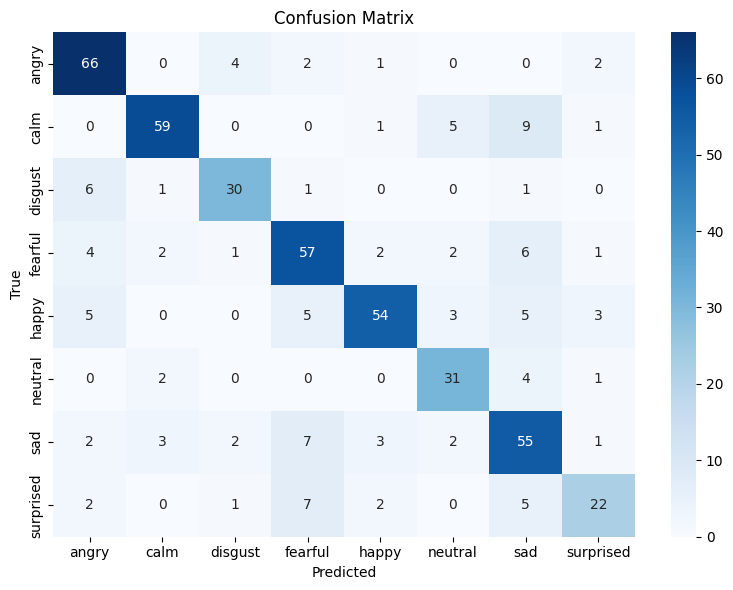

In [7]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the best model
model = load_model('/kaggle/working/best_model.h5')

# Predict class probabilities and convert to class labels
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Classification report
print(classification_report(y_val, y_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()